## [SEE THIS NOTEBOOK FOR HOW WE DEFINED "SALTINESS"](https://colab.research.google.com/drive/1M8gBDOieb8dcBW4Sr7TKlnlQD1s6-u-V)

# Hacker News Data Processing


In [1]:
from textblob import TextBlob
import bokeh
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import html 
import dask
import re
import dask.dataframe as dd
from tqdm import tqdm_pandas
from tqdm import tqdm_notebook as tqdm
import json

def save_df(df):
    df.to_pickle('data/df_save.pkl')
    print('Dataframe Saved')
    
def load_df():
    df = pd.read_pickle('data/df_save.pkl')
    print('Dataframe Loaded')
    return df

# Load TQDM
tqdm_pandas(tqdm())

# Load the profiler into Jupyter notebook
%load_ext line_profiler

## Part A. Get the data.

### Ran the query in Google BigQuery and copied the files to Google Cloud Storage

Then I moved my query data to Google Cloud Storage, downloaded it via the Jupyter Terminal onto my notebook server. 

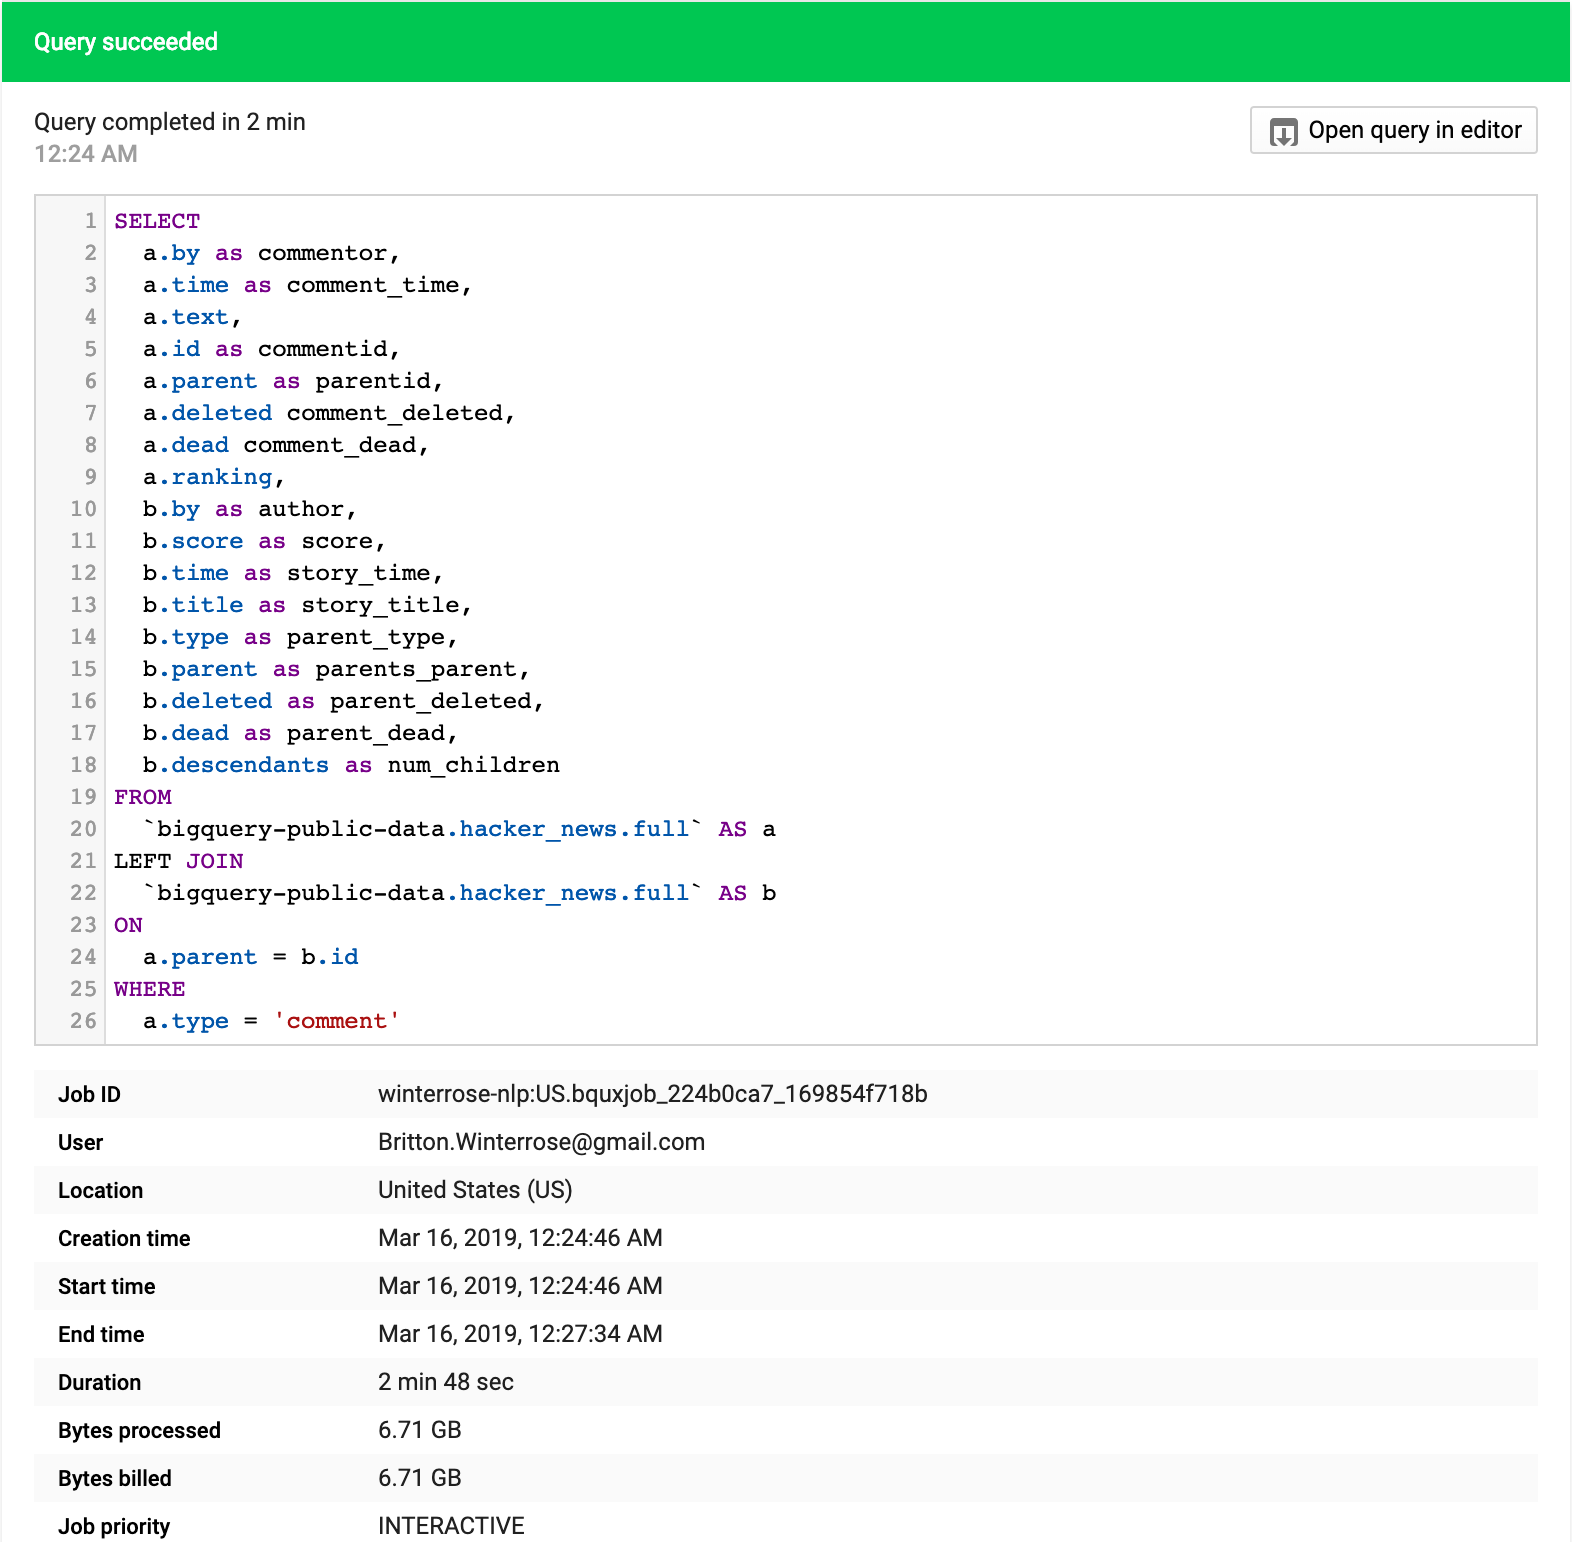

### Dask is giving me errors when I tried to .read( `*.csv` ). Manual approach:

In [2]:
%%time
#dask kept giving me errors. 
d0 = pd.read_csv('data/hn_main_query/hacker_news_full_comments0.csv',engine='python')
print("dataframe1")
d1 = pd.read_csv('data/hn_main_query/hacker_news_full_comments1.csv',engine='python')
print("dataframe2")
d2 = pd.read_csv('data/hn_main_query/hacker_news_full_comments2.csv',engine='python')
print("dataframe3")
d3 = pd.read_csv('data/hn_main_query/hacker_news_full_comments3.csv',engine='python')
print("dataframe4")
d4 = pd.read_csv('data/hn_main_query/hacker_news_full_comments4.csv',engine='python')
print("dataframe5")
d5 = pd.read_csv('data/hn_main_query/hacker_news_full_comments5.csv',engine='python')
print("dataframe6")
d6 = pd.read_csv('data/hn_main_query/hacker_news_full_comments6.csv',engine='python')
print("dataframe7")
d7 = pd.read_csv('data/hn_main_query/hacker_news_full_comments7.csv',engine='python')
print("dataframe8")
d8 = pd.read_csv('data/hn_main_query/hacker_news_full_comments8.csv',engine='python')
print("dataframe9")
d9 = pd.read_csv('data/hn_main_query/hacker_news_full_comments9.csv',engine='python')

dataframe1
dataframe2
dataframe3
dataframe4
dataframe5
dataframe6
dataframe7
dataframe8
dataframe9
CPU times: user 5min 55s, sys: 12.8 s, total: 6min 8s
Wall time: 5min 3s


In [3]:
%%time
df = pd.concat([d0, d1, d2, d3, d4, d5, d6, d7, d8, d9])

CPU times: user 49.8 s, sys: 5.05 s, total: 54.8 s
Wall time: 11.4 s


### Inspect shape of concatenated csv import. Verify that all rows are present. (15,825,859) 

In [4]:
display(df.shape)
display(df.head(10))

(15825859, 17)

commentor  comment_time  \
0       Twisell    1548920587   
1        camus2    1396456650   
2          acqq    1524697885   
3        aestra    1392397390   
4  AnimalMuppet    1459789890   
5      walshemj    1441142042   
6     acgourley    1389287479   
7          dang    1447809451   
8      lewis500    1531764004   
9       coldpie    1444395265   

                                                text  commentid  parentid  \
0  How come this is already gone from the front p...   19043154  19035834   
1  You could still maintain a level of compatibil...    7516784   7516418   
2  Just that word wouldn&#x27;t be unambiguous, e...   16927263  16923511   
3  I had a friend call the paramedics from home w...    7239514   7234721   
4  You don&#x27;t see a difference in whether or ...   11423531  11422828   
5  What with one of Tommy Flowers colleagues movi...   10155794  10152729   
6  App store review times? It&#x27;s generally 5 ...    7031649   7029685   
7  Quite a few have hit HN: <a href="https:&#x2F;...   10585266  10584911   
8  Yeah all I see here is incoherent posturing.<p...   17543424  17543252   
9                        So, use an open source one.   10359666  10359613   

  comment_deleted comment_dead  ranking          author  score    story_time  \
0             NaN          NaN      NaN           epaga  731.0  1.548862e+09   
1             NaN          NaN      NaN         kelvin0    NaN  1.396454e+09   
2             NaN          NaN      NaN     celticninja    NaN  1.524675e+09   
3             NaN          NaN      NaN          taybin    NaN  1.392329e+09   
4             NaN          NaN      NaN          aantix    NaN  1.459785e+09   
5             NaN          NaN      NaN           zeveb    NaN  1.441119e+09   
6             NaN          NaN      NaN              oe    NaN  1.389263e+09   
7             NaN          NaN      NaN      BeefySwain    NaN  1.447805e+09   
8             NaN          NaN      NaN          aeleos    NaN  1.531763e+09   
9             NaN          NaN      NaN  colinplamondon    NaN  1.444395e+09   

                                         story_title parent_type  \
0  Apple blocks Facebook from running its interna...       story   
1                                                NaN     comment   
2                                                NaN     comment   
3                                                NaN     comment   
4                                                NaN     comment   
5                                                NaN     comment   
6                                                NaN     comment   
7                                                NaN     comment   
8                                                NaN     comment   
9                                                NaN     comment   

   parents_parent parent_deleted parent_dead  num_children  
0             NaN            NaN         NaN         308.0  
1       7515297.0            NaN         NaN           NaN  
2      16920528.0            NaN         NaN           NaN  
3       7234703.0            NaN         NaN           NaN  
4      11422692.0            NaN         NaN           NaN  
5      10152484.0            NaN         NaN           NaN  
6       7029656.0            NaN         NaN           NaN  
7      10574900.0            NaN         NaN           NaN  
8      17542699.0            NaN         NaN           NaN  
9      10359491.0            NaN         NaN           NaN

### Remove all  `author` and `text` NaN rows from Dataframe. 

In [5]:
nans = df.text.isna().sum()
print('This many nans:', nans)
df = df.dropna(subset=['commentor', 'text'])
print('New Shape after nan removal:', df.shape)

nans = df.parent_type.isna().sum()
print('This many parent_type nans:', nans)
nans = df.story_title.isna().sum()
print('This many story_title nans:', nans)

This many nans: 428547
New Shape after nan removal: (15397309, 17)
This many parent_type nans: 0
This many story_title nans: 11238756


### Fill in empty `parent_titles` for each comment. 

In [6]:
%%time
df['story_title'] = df.story_title.fillna('Another Comment')
nans = df.story_title.isna().sum()
print('This many story_title nans:', nans)
display(df.head(3))

This many story_title nans: 0


commentor  comment_time                                               text  \
0   Twisell    1548920587  How come this is already gone from the front p...   
1    camus2    1396456650  You could still maintain a level of compatibil...   
2      acqq    1524697885  Just that word wouldn&#x27;t be unambiguous, e...   

   commentid  parentid comment_deleted comment_dead  ranking       author  \
0   19043154  19035834             NaN          NaN      NaN        epaga   
1    7516784   7516418             NaN          NaN      NaN      kelvin0   
2   16927263  16923511             NaN          NaN      NaN  celticninja   

   score    story_time                                        story_title  \
0  731.0  1.548862e+09  Apple blocks Facebook from running its interna...   
1    NaN  1.396454e+09                                    Another Comment   
2    NaN  1.524675e+09                                    Another Comment   

  parent_type  parents_parent parent_deleted parent_dead  num_children  
0       story             NaN            NaN         NaN         308.0  
1     comment       7515297.0            NaN         NaN           NaN  
2     comment      16920528.0            NaN         NaN           NaN

CPU times: user 19.7 s, sys: 316 ms, total: 20 s
Wall time: 4.26 s


## Part B. Apply Sentiment Analysis and more Text Cleaning

### Define utility functions

In [7]:
def encode_decode(text):
    """Utility function to clean text by decoding HTML text."""
    unescaped = html.unescape(text)
    return unescaped


def noHTML(text):
    """Utility function to clean text by removing HTML flags."""
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    return cleantext


def noURLS(text):
    """Utility function to clean text by removing links using simple regex."""
    return ''.join(re.sub(r"http\S+", "", text))


def get_sentiment(text):
    """Evaluates the sentiment of given text.
    
    Utility function to classify sentiment of passed text
    using textblob's sentiment method. Return the polarity
    score as a float within the range [-1.0, 1.0]
    
    Polarity score is a float within the range [-1.0, 1.0] 
    where negative value indicates negative text 
    and positive value indicates that the given 
    text is positive.

    Subjectivity is a float within the range [0.0, 1.0] 
    where 0.0 is very objective and 1.0 is very subjective.
    
    Args:
        text: the text of a comment.
    
    Returns:
        polarity
        subjectivity
    """
    analysis = TextBlob(text).sentiment
    polarity = analysis.polarity
    subjectivity = analysis.subjectivity
    return polarity, subjectivity



### Apply text cleaning to comment texts and create new column in Dataframe

In [8]:
df['cleaned_comment'] = df.text.progress_apply(lambda x: noURLS(noHTML(encode_decode(x))))
df['cleaned_title'] = df.story_title.progress_apply(lambda x: noURLS(noHTML(encode_decode(x))))

### Apply sentiment analysis (TextBlob.polarity) to each cleaned Comment text. 

In [ ]:
df['comment_sentiment'] = df.cleaned_comment.progress_apply(get_sentiment)
df.iloc[:, -6:].head(3)

### Drop the original *uncleaned* columns

In [ ]:
df = df.drop(columns=['text', 'story_title'])

### Split the comment sentiment tuple into `polarity` and `subjectivity` then replace `comment sentiment`

In [ ]:
%%time
alt_df = pd.DataFrame(df['comment_sentiment'].tolist(), index=df.index)
alt_df.columns = ['polarity', 'subjectivity']
df["comment_polarity"] = alt_df.polarity
df["comment_subjectivity"] = alt_df.subjectivity
df = df.drop(columns=['comment_sentiment'])
df.head(3)

In [ ]:
%%time
df.to_csv('data/hn_all_w_sentiment_cleaned_inplace.csv',index=False)

## Part C.  Load cleaned / analyzed data back into dataframe from CSV

In [19]:
%%time
# IMPORT FROM CSV's
df = pd.read_csv('data/hn_all_w_sentiment_cleaned_inplace.csv')
print(df.shape)

(15397309, 19)
CPU times: user 1min 45s, sys: 10.6 s, total: 1min 56s
Wall time: 1min 45s


### Do some Data Cleanup

In [20]:
%%time
nans = df.comment_deleted.isna().sum()
print('This many nans:', nans)
nans = df.comment_dead.isna().sum()
print('This many nans:', nans)
nans = df.parent_deleted.isna().sum()
print('This many nans:', nans)
nans = df.parent_dead.isna().sum()
print('This many nans:', nans)

df['comment_deleted'] = df.comment_deleted.fillna(value=False)
df['comment_dead'] = df.comment_dead.fillna(value=False)
df['parent_deleted']  = df.parent_deleted.fillna(value=False)
df['parent_dead']  = df.parent_dead.fillna(value=False)


This many nans: 15397309
This many nans: 15202774
This many nans: 15370200
This many nans: 15274890
CPU times: user 1min 42s, sys: 6.33 s, total: 1min 49s
Wall time: 23 s


In [21]:
%%time
nans = df.comment_deleted.isna().sum()
print('This many comment_deleted nans:', nans)
nans = df.comment_dead.isna().sum()
print('This many comment_dead nans:', nans)
nans = df.parent_deleted.isna().sum()
print('This many parent_deleted nans:', nans)
nans = df.parent_dead.isna().sum()
print('This many parent_dead nans:', nans)
nans = df.ranking.isna().sum()
print('This many ranking nans:', nans)

This many comment_deleted nans: 0
This many comment_dead nans: 0
This many parent_deleted nans: 0
This many parent_dead nans: 0
This many ranking nans: 15397309
CPU times: user 26.2 s, sys: 1.95 ms, total: 26.2 s
Wall time: 1.18 s


### Oops, looks like `ranking` column was actually empty for each `comment` on that BigQuery `full` table. I'll need to pull it in from a different table and merge it here by commentid from the comments table. 

After a bit of investigation I found that the table `bigquery-public-data.hacker_news.full_201510` does contain `comment_ranking` type entries, but the `bigquery-public-data.hacker_news.full` (the one that is continuously updated) does not. 

I'm going to add in the comment_ranking data as a column, but not calculate any summary stats off it for the API. 

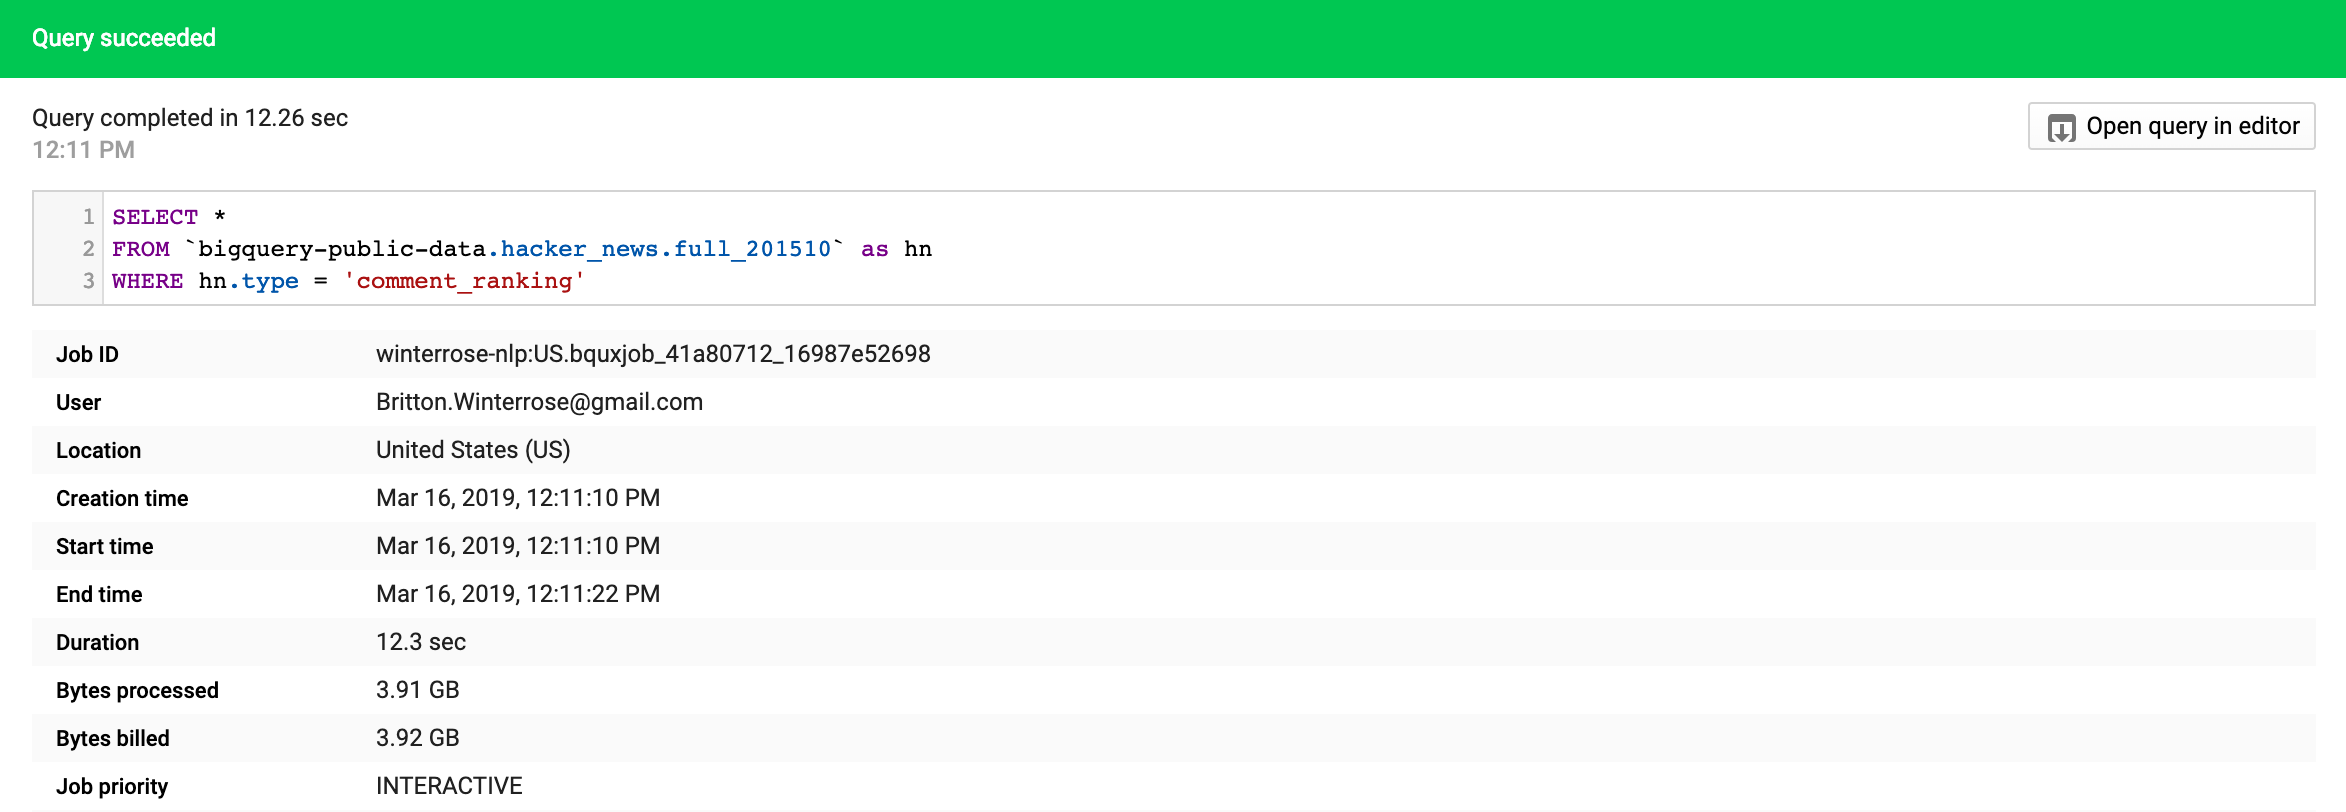

In [22]:
%%time
comment_ranking_df = pd.read_csv("data/comment_ranking.csv")
comment_ranking_df = comment_ranking_df[['id','ranking']].copy()
comment_ranking_df.set_index('id')
comment_ranking_df.head(3)

CPU times: user 13.9 s, sys: 3.91 s, total: 17.9 s
Wall time: 5.82 s


### Add in the missing `ranking` data

In [23]:
%%time
df = df.drop(columns=['ranking'])
df = df.merge(comment_ranking_df, how='left', left_on='commentid', 
              right_on='id')

CPU times: user 30.1 s, sys: 5.84 s, total: 35.9 s
Wall time: 28.5 s


In [24]:
nans = df.ranking.isna().sum()
print('This many ranking nans:', nans)
print(df.columns)

This many ranking nans: 7226283
Index(['commentor', 'comment_time', 'commentid', 'parentid', 'comment_deleted',
       'comment_dead', 'author', 'score', 'story_time', 'parent_type',
       'parents_parent', 'parent_deleted', 'parent_dead', 'num_children',
       'cleaned_comment', 'cleaned_title', 'comment_polarity',
       'comment_subjectivity', 'id', 'ranking'],
      dtype='object')


## Part D.  Make some features to aid in the final stat aggregation.

### Fill Nan's and rename columns so API (JSON) is easier to read. 

In [25]:
%%time
df = df.fillna(value=0)
df = df.rename(columns={'author': 'parent_author', 
                        'cleaned_title': 'parent_title',
                        'score': 'parent_score', 
                        'story_time': 'parent_time', 
                        'ranking': 'comment_rank',
                        'commentid':'comment_id',
                        'parentid':'parent_id'})

df = df.drop(columns=['id'])
df = df.sort_values(by = ['comment_subjectivity','comment_polarity'])
display(df.head(3))
display(df.tail(3))

commentor  comment_time  comment_id  parent_id  comment_deleted  \
5449963  Allocator2008    1242652127      614896     614712            False   
6244275  pankajdoharey    1506373773    15334179   15332819            False   
4331859         eyeJam    1424278947     9069538    9069282            False   

         comment_dead parent_author  parent_score   parent_time parent_type  \
5449963          True      mstevens          59.0  1.242642e+09       story   
6244275          True          GuiA        1174.0  1.506364e+09       story   
4331859         False      coldcode          11.0  1.424277e+09       story   

         parents_parent  parent_deleted  parent_dead  num_children  \
5449963             0.0           False        False          20.0   
6244275             0.0           False        False         618.0   
4331859             0.0           False        False           3.0   

                                           cleaned_comment  \
5449963          OMG, they killed Kenny!!! You bastards!!!   
6244275  Stan : OH My GOD - they Killed Whatsapp!! Kyle...   
4331859  "making his prior investment in his theater de...   

                                              parent_title  comment_polarity  \
5449963  The Death of Richard Dawkins: A short story by...         -0.762939   
6244275                              China Blocks WhatsApp         -0.610352   
4331859  Tulsa University Bans Student from Campus for ...         -0.500000   

         comment_subjectivity  comment_rank  
5449963                   0.0           8.0  
6244275                   0.0           0.0  
4331859                   0.0           2.0

commentor  comment_time  comment_id  parent_id  comment_deleted  \
15396247   Porter_423    1335509610     3897919    3897723            False   
15396324  caseorganic    1356906450     4987376    4987309            False   
15396875        ac360    1425005188     9116906    9116331            False   

          comment_dead parent_author  parent_score   parent_time parent_type  \
15396247          True  paulgerhardt          68.0  1.335505e+09       story   
15396324         False     kyledrake          13.0  1.356905e+09       story   
15396875         False        inglor         225.0  1.424994e+09       story   

          parents_parent  parent_deleted  parent_dead  num_children  \
15396247             0.0           False        False          12.0   
15396324             0.0           False        False           3.0   
15396875             0.0           False        False          77.0   

                                            cleaned_comment  \
15396247                                     simply awesome   
15396324  Somewhere Street is awesome and a bit like pla...   
15396875  Why reconcile?  This is awesome competition.  ...   

                                               parent_title  comment_polarity  \
15396247  31 Years Later, "Star Castle" Finally Ported t...               1.0   
15396324  Show HN: Interesting documentaries from Japan,...               1.0   
15396875          Io.js and Node.js reconciliation proposal               1.0   

          comment_subjectivity  comment_rank  
15396247                   1.0           5.0  
15396324                   1.0           0.0  
15396875                   1.0           5.0

CPU times: user 2min 6s, sys: 27.7 s, total: 2min 33s
Wall time: 1min 7s


### Make a copy of the Dataframe to preserve our work incase of error. 

In [37]:
data = df

### Normalize comment subjectivity from sub `-1 to 1` to obj. Create booleans for +/- classes. 

In [38]:
%%time

def sentiment_helpers(df):
    """Creates new columns in the given dataframe
    
    Comment Subjectivity: 
    
        Type:   Float, 0.0 to 1.0, 
        Legend: 0 = Objective, 1 = Subjective 
        Calc:   x = TextBlob(text).sentiment.subjectivity, 
        f(x):   get_sentiment
        Use:    Seperate critisism from saltiness & enthusiasum from support.
                As subjectivity decreases sentiment becomes less personal, 
                more objective. 
        
    Comment Saltiness:
    
        Type:   Float, -1.0 to 0.0 to 1.0, 
        Legend: -1 = Salty,  0 = Neutral,  1 = Enthuisastic
        Calc:   TextBlob(text).sentiment.subjectivity * 
                TextBlob(text).sentiment.polarity
        Use:    Seperate critisism from saltiness & enthusiasum from support.
                As subjectivity decreases sentiment is less personal, 
                more objective. 
    
    Subjectivity_spectrum(Revised): 
    
        Type:   Float,  -1.0 to 1.0, 
        Legend: -1 = Objective, 1 = Subjective 
        Calc:   x = TextBlob(text).sentiment.subjectivity, Negated, center on 
                zero, multiply by 2. 
        f(x):   get_sentiment
        Use:    Seperate critisism from saltiness & enthusiasum from support.
                Used for graphing -1 to 1 Arc & Bar data. 
                As subjectivity decreases sentiment is less personal, 
                more objective.
    
    Boolean Columns: 
        Used for filtering - is_subjective, is_negative, is_salty

    Args:
        df: The full comment dataframe.    
    """
    df['comment_saltiness'] = (df['comment_polarity']
                               .multiply(df['comment_subjectivity']))
    df['subjectivity_spectrum'] = (df['comment_subjectivity'].multiply(-1)
                                   .add(.5).multiply(2))
    df['is_subjective'] = (df['comment_subjectivity']
                           .map(lambda x: True if (x > .5) else False))
    df['is_negative'] = (df['comment_polarity']
                         .map(lambda x: True if (x < 0) else False))
    df['is_salty'] = (df['comment_saltiness']
                      .map(lambda x: True if (x < 0) else False))
    print ("Sentiment helpers created...")


sentiment_helpers(data)


Sentiment helpers created...
CPU times: user 31.5 s, sys: 541 ms, total: 32.1 s
Wall time: 9.66 s


In [39]:
%%time
# Should see spectrum from -1 to 1, and saltiness -1 to 0 (from diminishing effect of objectivity). 
data = data.sort_values(by = ['subjectivity_spectrum','comment_saltiness'])
display(data.iloc[:,-6:].head(3))
display(data.iloc[:,-6:].tail(3))

comment_rank  comment_saltiness  subjectivity_spectrum  is_subjective  \
1287           8.0               -1.0                   -1.0           True   
1711           0.0               -1.0                   -1.0           True   
4310           0.0               -1.0                   -1.0           True   

      is_negative  is_salty  
1287         True      True  
1711         True      True  
4310         True      True

comment_rank  comment_saltiness  subjectivity_spectrum  \
13303123           0.0                0.0                    1.0   
4723851            2.0                0.0                    1.0   
2384549            4.0                0.0                    1.0   

          is_subjective  is_negative  is_salty  
13303123          False        False     False  
4723851           False        False     False  
2384549           False        False     False

CPU times: user 37 s, sys: 0 ns, total: 37 s
Wall time: 9.07 s


### Create `quadrant` column for categorical class for use in Groupby function.

In [40]:
%%time

def determine_quadrant(df):
    """Calculates Quadrants and creates column. 

    Creates columns for a polarity/subjectivity quadrant type groupby filter.
    Quadrants are as follows:
        `neg_obj` - Critic
        `neg_sub` - Salty
        `pos_obj` - Advocate
        `pos_sub` - Happy 
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: The same dataframe with added `quadrants` column.
    """
    df['polarity'] = (df['comment_polarity'].map(lambda x:'neg' 
                                                 if (x < 0) else 'pos'))
    df['basis'] = (df['comment_subjectivity'].map(lambda x: 'sub' 
                                                  if (x > .5) else 'obj'))
    df = df.assign(quadrant=[str(x) + '_' + str(y) for x, y
                             in zip(df['polarity'], df['basis'])])
    df = df.drop(columns=['polarity','basis'])
    return df


data = determine_quadrant(data)

CPU times: user 1min 10s, sys: 595 ms, total: 1min 11s
Wall time: 1min


In [41]:
display(data.shape)
display(data.iloc[0:2, -8:])

(15397309, 25)

comment_subjectivity  comment_rank  comment_saltiness  \
1287                   1.0           8.0               -1.0   
1711                   1.0           0.0               -1.0   

      subjectivity_spectrum  is_subjective  is_negative  is_salty quadrant  
1287                   -1.0           True         True      True  neg_sub  
1711                   -1.0           True         True      True  neg_sub

### Send every row of these columns into a Json string. 

In [42]:
%%time

def create_comment_JSON_records(df):
    """Turns comments + stats into json objects, creates column in given df.
    
    Saves filtered dataframe columns as json object oriented on row records. 
    Decodes the JSON string into a list containing 1 JSON object per row.
    Adds new column in the given dataframe that stores the row's JSON Object.
    
    Args:
        df: The full comment dataframe.    
    """
    saved = (df[['commentor', 'comment_time', 'comment_saltiness',
                 'comment_polarity', 'comment_subjectivity', 
                 'subjectivity_spectrum', 'is_salty', 'is_subjective',
                 'is_negative', 'parent_type', 'parent_author', 'parent_title',
                 'cleaned_comment', 'comment_rank', 'comment_id', 'parent_id']]
             .to_json(orient='records'))
    decoded = json.JSONDecoder().decode(saved)
    df['comment_JSON'] = decoded
    print( "JSON Uploaded")


create_comment_JSON_records(data)

JSON Uploaded
CPU times: user 2min 28s, sys: 15.8 s, total: 2min 44s
Wall time: 2min 43s


In [43]:
display(data.shape)
display(data.iloc[0:2, -6:])

(15397309, 26)

subjectivity_spectrum  is_subjective  is_negative  is_salty quadrant  \
1287                   -1.0           True         True      True  neg_sub   
1711                   -1.0           True         True      True  neg_sub   

                                           comment_JSON  
1287  {'commentor': 'Aloisius', 'comment_time': 1337...  
1711  {'commentor': 'VikingCoder', 'comment_time': 1...

In [44]:
data.iloc[3:4].comment_JSON.values

array([{'commentor': 'zethraeus', 'comment_time': 1366028380, 'comment_saltiness': -1.0, 'comment_polarity': -1.0, 'comment_subjectivity': 1.0, 'subjectivity_spectrum': -1.0, 'is_salty': True, 'is_subjective': True, 'is_negative': True, 'parent_type': 'comment', 'parent_author': 'scrapcode', 'parent_title': 'Another Comment', 'cleaned_comment': "Publicity for their situation - which is terrible. A prisoner's attempt to get publicity does not influence the morality or legality of practices at Guantanamo Bay.", 'comment_rank': 3.0, 'comment_id': 5551018, 'parent_id': 5550952}],
      dtype=object)

### Get a count of how many unique commentors are in this data

In [45]:
%%time
userKeys = data["commentor"]
ukeys, index = np.unique(userKeys, True)
display(ukeys.shape)

(388120,)

CPU times: user 49.7 s, sys: 310 ms, total: 50 s
Wall time: 49.7 s


### Export a Sample of our data to compare polarity vs saltiness to see how it effects the spread.

Doing this to gut-check our assumptions of how our calculated metric `saltiness` will function. 
(*See link at top of notebook.*) 

In [46]:
data_sample = data[['comment_polarity','comment_saltiness',
                    'comment_subjectivity','is_subjective','is_negative',
                    'is_salty','quadrant']].sample(n=100000, random_state=42)

data_sample.to_pickle('data/polarity_salty_compare.pkl')
print('Dataframe Saved')

Dataframe Saved


## Part E.  Create groupby stats for our selected metrics

### Calculate Commentor `count comments` & `first/latest` comment dates. 

Also create Dataframe_Commentor_Table, `df_ct`.

In [47]:
%%time

def commentor_stats(df):
    """Returns stats about the commentor's comment history 
    
    Groups by `commentor` and calculates agg stats for 'count',`min`, `max`.
    
    Columns Created:
        `count_comments` - count the number of comments.
        `time_of_last_comment`  - Unix Epoch time of the last comment before our
                                  data was pulled on Mar 16, 2019, 12:24:46 AM.
        `time_of_first_comment` - Unix Epoch time of the earliest comment. 
    
    Args:
        df: The full comment dataframe.

    Returns: 
        out: A dataframe with index `commentor` and created columns.
    """
    out = (df.groupby('commentor', as_index=False)['comment_time']
           .agg(['count','max','min']))
    out = out.rename({'count': 'count_comments',
                      'max': 'time_of_last_comment',
                      'min': 'time_of_first_comment'}, axis='columns')
    print("Calculated commentor stats.")
    return out


# Run Function & create df_ct
df_ct = commentor_stats(data)

Calculated commentor stats.
CPU times: user 12.9 s, sys: 349 ms, total: 13.3 s
Wall time: 6.72 s


In [48]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 3)

count_comments  time_of_last_comment  time_of_first_comment
commentor                                                                 
0-                          1            1394798525             1394798525
0--__-_-__--0               1            1541102045             1541102045
0-0                         1            1259867712             1259867712

### Group `Count` & `Sum` of the Saltiness Scores by Month for Plotting. Create list of plotpoints for each Commentor. 

In [49]:
%%time

def calculate_monthly_summaries(df):
    """Creates summary of stats over `commentors` history by month for graphing.
    
    Calculates the `count` and `sum` aggregated stats of `comment_saltiness`
    grouped by `is_salty` & `month_text`. 
    Formats the stats into a JSON object for each commenters' period.
    Concatenates JSON Objects into a sequential sparse list (no empty months) 
    for each commentor. 
    
    Stats in the `montly_plot` list are:
        y_m: Year-Month period of stat aggregation from the `month-text` group.
        c_h: Stat, count of Happy Comments for the month.
        c_s: Stat, count of Salty Comments for the month.
        t_h: Stat, total (sum) of Happy Comment Scores for the month.
        t_s: Stat, total (sum) of Salty Comment Scores for the month.
    
    Args:
        df: The full comment dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column `monthly_plot`. 
    """
    df['month_text'] = (pd.to_datetime(df['comment_time'],unit='s')
                        .dt.strftime('%Y_%m')).str[-5:]
    
    out = df['comment_saltiness'].groupby([df['commentor'], 
                                           df['month_text'],
                                           df['is_salty']]
                                         ).agg(['count','sum']).unstack()
    
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('count', False)": 'c_h', # Count Happy 
                      "('count', True)": 'c_s', # Count Salty
                      "('sum', False)": 't_h', # Sum Happy
                      "('sum', True)": 't_s'}, axis='columns') # Sum Salty 
    print("Calculated monthly stats")
    
    # Combine the monthly_stats into an object. 
    out.reset_index(inplace=True)
    out = out.rename({"month_text": 'y_m'},axis='columns')
    out = out.fillna(0.0)
    out["t_h"] = out["t_h"].round(decimals=2)
    out["t_s"] = out["t_s"].round(decimals=2)
    out_json = (out[["y_m","t_s","t_h","c_s","c_h"]].to_json(orient='records'))
    decoded = json.JSONDecoder().decode(out_json)
    out['monthly_graph'] = decoded
    
    # Combine the montly_stats_object into a list for each commentor.
    out.sort_values(['commentor','y_m'], ascending=[True, True])
    keys, values = out[['commentor', 'monthly_graph']].values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'monthly_plot':[list(a) for a in arrays]},
                      index = ukeys)
    print("Created monthly stat lists.")  
    return df


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, calculate_monthly_summaries(data),
                 left_index=True, right_index=True, how='left')

Calculated monthly stats
Created monthly stat lists.
CPU times: user 3min 43s, sys: 5.44 s, total: 3min 48s
Wall time: 1min 53s
Parser   : 129 ms


In [50]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(5))
display(df_ct.iloc[3:5].monthly_plot.values)

(388120, 4)

count_comments  time_of_last_comment  time_of_first_comment  \
commentor                                                                    
0-                          1            1394798525             1394798525   
0--__-_-__--0               1            1541102045             1541102045   
0-0                         1            1259867712             1259867712   
0-4                        12            1288646410             1288394371   
0-9                         2            1524324694             1477669562   

                                                    monthly_plot  
commentor                                                         
0-             [{'y_m': '14_03', 't_s': 0.0, 't_h': 0.12, 'c_...  
0--__-_-__--0  [{'y_m': '18_11', 't_s': -0.01, 't_h': 0.0, 'c...  
0-0            [{'y_m': '09_12', 't_s': -0.28, 't_h': 0.0, 'c...  
0-4            [{'y_m': '10_10', 't_s': -0.01, 't_h': 0.71, '...  
0-9            [{'y_m': '16_10', 't_s': 0.0, 't_h': 0.0, 'c_s...

array([list([{'y_m': '10_10', 't_s': -0.01, 't_h': 0.71, 'c_s': 2.0, 'c_h': 9.0}, {'y_m': '10_11', 't_s': 0.0, 't_h': 0.06, 'c_s': 0.0, 'c_h': 1.0}]),
       list([{'y_m': '16_10', 't_s': 0.0, 't_h': 0.0, 'c_s': 0.0, 'c_h': 1.0}, {'y_m': '18_04', 't_s': 0.0, 't_h': 0.06, 'c_s': 0.0, 'c_h': 1.0}])],
      dtype=object)

### Create the 50 `top_cmnts_s `list for each Commentor - Filter by `is_salty`

In [51]:
%%time 

def top_salty_comments(df):
    """Creates list object for each `commentor` of top 50 saltiest comments. 
    
    Filters by `is_salty` = True.
    Sorts values by `comment_saltiness` from the most salty (lowest value).
    Groups dataframe by `commentor'.
    Concatenates top 50 `comment_JSON` comment objects into a list object.
    Creates a new column from the list of obj(commentor's list of json objects).
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: A dataframe w/ index `commentor` and a column 'top_cmnts_s'.
    """
    # Grab the right comments, pulls up to 50 comments by saltiest.
    df = df[df['is_salty'] == True]
    df = df.sort_values(['commentor','comment_saltiness'],
                        ascending=[True, True])
    df = (df[['commentor','comment_JSON']].groupby(df['commentor']).head(50)
          .reset_index(drop=True))
    
    # Group the comments into a list for each user.
    keys, values = df.values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'top_cmnts_s':[list(a) for a in arrays]},
                      index = ukeys)
    print("Grabbed the SALTIEST comments.")
    return df   


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, top_salty_comments(data),
                 left_index=True, right_index=True, how='left')

Grabbed the SALTIEST comments.
CPU times: user 49.8 s, sys: 2.17 s, total: 51.9 s
Wall time: 33.4 s
Compiler : 512 ms


In [52]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(5))

(388120, 5)

count_comments  time_of_last_comment  time_of_first_comment  \
commentor                                                                    
0-                          1            1394798525             1394798525   
0--__-_-__--0               1            1541102045             1541102045   
0-0                         1            1259867712             1259867712   
0-4                        12            1288646410             1288394371   
0-9                         2            1524324694             1477669562   

                                                    monthly_plot  \
commentor                                                          
0-             [{'y_m': '14_03', 't_s': 0.0, 't_h': 0.12, 'c_...   
0--__-_-__--0  [{'y_m': '18_11', 't_s': -0.01, 't_h': 0.0, 'c...   
0-0            [{'y_m': '09_12', 't_s': -0.28, 't_h': 0.0, 'c...   
0-4            [{'y_m': '10_10', 't_s': -0.01, 't_h': 0.71, '...   
0-9            [{'y_m': '16_10', 't_s': 0.0, 't_h': 0.0, 'c_s...   

                                                     top_cmnts_s  
commentor                                                         
0-                                                           NaN  
0--__-_-__--0  [{'commentor': '0--__-_-__--0', 'comment_time'...  
0-0            [{'commentor': '0-0', 'comment_time': 12598677...  
0-4            [{'commentor': '0-4', 'comment_time': 12883946...  
0-9                                                          NaN

### Get the `top_salty_comment` for each Commentor - Need it for `Rank` Lists

In [53]:
%%time 

def the_top_salty_comment(df):
    """Returns the top salty comment of each `commentor`. 
    
    Filters by `is_salty`
    Sorts on `commentor` and `comment_saltiness` to bring saltiest to top.
    Groups dataframe by `commentor`. 
    Creates a list containing the top comment for each `commentor`. 
    Turns the list into a new column: `top_salty_comment`
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: A dataframe w/ index `commentor` and column `top_salty_comment`.
    """
    # Grab the right comments, will pull the top salty comment.
    df = df[df['is_salty'] == True]
    df = df.sort_values(['commentor','comment_saltiness'],
                        ascending=[True, True])
    df = (df[['commentor','comment_JSON']].groupby(df['commentor']).head(1)
          .reset_index(drop=True))
    
    # Group the comments into a list for each user.
    keys, values = df.values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'top_salty_comment':[list(a) for a in arrays]},
                      index = ukeys)
    print("Grabbed the top SALTIEST comment.")
    return df   


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, the_top_salty_comment(data),
                 left_index=True, right_index=True, how='left')

Grabbed the top SALTIEST comment.
CPU times: user 33 s, sys: 726 ms, total: 33.7 s
Wall time: 13.5 s


### Group the top 20 `Happy` Comments for each commentor - Filter by `is_salty`

In [54]:
%%time 

def top_happy_comments(df):  
    """ Creates list object for each `commentor` of their top 50 happy comments. 
    
    Filters by `is_salty` = False 
    Sorts values by `comment_saltiness` from the most happy (highest value).
    Groups dataframe by `commentor'.
    Concatenates top 20 `comment_JSON` comment objects into a list object.
    Creates a new column from the list of obj(commentor's list of json objects).
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: A dataframe w/ index `commentor` and column `top_cmnts_h`.
    """
    # Grab the right comments, will pull up to 20 comments by happiest.
    df = df[df['is_salty'] == False]
    df = df.sort_values(['commentor','comment_saltiness'],
                        ascending=[True, False])
    df = (df[['commentor','comment_JSON']].groupby(df['commentor']).head(20)
          .reset_index(drop=True))
    
    # Group the comments into a list for each user.
    keys, values = df.values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'top_cmnts_h':[list(a) for a in arrays]},
                      index = ukeys)
    print("Grabbed the HAPPIEST comments.")
    return df   


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, top_happy_comments(data),
                 left_index=True, right_index=True, how='left')


Grabbed the HAPPIEST comments.
CPU times: user 1min 25s, sys: 3.97 s, total: 1min 29s
Wall time: 1min 2s


In [55]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 7)

time_of_last_comment  time_of_first_comment  \
commentor                                                    
0-                       1394798525             1394798525   
0--__-_-__--0            1541102045             1541102045   
0-0                      1259867712             1259867712   

                                                    monthly_plot  \
commentor                                                          
0-             [{'y_m': '14_03', 't_s': 0.0, 't_h': 0.12, 'c_...   
0--__-_-__--0  [{'y_m': '18_11', 't_s': -0.01, 't_h': 0.0, 'c...   
0-0            [{'y_m': '09_12', 't_s': -0.28, 't_h': 0.0, 'c...   

                                                     top_cmnts_s  \
commentor                                                          
0-                                                           NaN   
0--__-_-__--0  [{'commentor': '0--__-_-__--0', 'comment_time'...   
0-0            [{'commentor': '0-0', 'comment_time': 12598677...   

                                               top_salty_comment  \
commentor                                                          
0-                                                           NaN   
0--__-_-__--0  [{'commentor': '0--__-_-__--0', 'comment_time'...   
0-0            [{'commentor': '0-0', 'comment_time': 12598677...   

                                                     top_cmnts_h  
commentor                                                         
0-             [{'commentor': '0-', 'comment_time': 139479852...  
0--__-_-__--0                                                NaN  
0-0                                                          NaN

### Calculate stats for Saltiness - `Overall`

In [56]:
%%time

def saltiness_stats(df):
    """Creates stats of `comment_saltiness` overall.
    
    First groups dataframe by `commentor`. 
    Aggregates `count`, `sum`, & `mean` stats of `comment_saltiness` by `is_salty`.
    Creates new column for each aggregate stat: 4 new columns.
    
    Args:
        df: The full comment dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df.groupby('commentor', as_index=False)['comment_saltiness']
           .agg(['sum', 'mean', 'min', 'max']))
    out = out.rename({'sum': 'sum_slt_oall',
                      'mean': 'average_slt_oall',
                      'min': 'min_slt_oall',
                      'max': 'max_slt_oall'}, axis='columns')
    print("Calculated saltiness overall stats.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, saltiness_stats(data), left_index=True,
                 right_index=True, how='left')

Calculated saltiness overall stats.
CPU times: user 14.6 s, sys: 196 ms, total: 14.8 s
Wall time: 7.25 s


In [57]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 11)

top_salty_comment  \
commentor                                                          
0-                                                           NaN   
0--__-_-__--0  [{'commentor': '0--__-_-__--0', 'comment_time'...   
0-0            [{'commentor': '0-0', 'comment_time': 12598677...   

                                                     top_cmnts_h  \
commentor                                                          
0-             [{'commentor': '0-', 'comment_time': 139479852...   
0--__-_-__--0                                                NaN   
0-0                                                          NaN   

               sum_slt_oall  average_slt_oall  min_slt_oall  max_slt_oall  
commentor                                                                  
0-                 0.120000          0.120000      0.120000      0.120000  
0--__-_-__--0     -0.006803         -0.006803     -0.006803     -0.006803  
0-0               -0.280000         -0.280000     -0.280000     -0.280000

### Calculate stats for Saltiness - Split `Happy/Salty`

In [58]:
%%time

def saltiness_stats_split(df):
    """Creates stats of `comment_saltiness` by `is_salty`. 
    
    First groups dataframe by `commentor`. 
    Aggregates `count`, `sum`, & `mean` stats of `comment_saltiness` by `is_salty`. 
    Creates new column for each aggregate stat: 6 new columns. 
    
    Args:
        df: The full comments dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df['comment_saltiness'].groupby([df['commentor'],df['is_salty']])
           .agg(['count','sum', 'mean']).unstack())
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('count', False)": 'cnt_slt_h',
                      "('count', True)": 'cnt_slt_s',
                      "('sum', False)": 'sum_slt_h',
                      "('sum', True)": 'sum_slt_s',
                      "('mean', False)":"avg_slt_h",
                      "('mean', True)":"avg_slt_s"},
                     axis='columns')
    print("Calculated saltiness grouped stats - split by salty/happy.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, saltiness_stats_split(data), left_index=True,
                 right_index=True, how='left')

Calculated saltiness grouped stats - split by salty/happy.
CPU times: user 42.5 s, sys: 814 ms, total: 43.3 s
Wall time: 8.95 s


In [59]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 17)

cnt_slt_h  cnt_slt_s  sum_slt_h  sum_slt_s  avg_slt_h  \
commentor                                                              
0-                   1.0        NaN       0.12        NaN       0.12   
0--__-_-__--0        NaN        1.0        NaN  -0.006803        NaN   
0-0                  NaN        1.0        NaN  -0.280000        NaN   

               avg_slt_s  
commentor                 
0-                   NaN  
0--__-_-__--0  -0.006803  
0-0            -0.280000

### Calculate stats for Saltiness - Split `Quadrant`

In [60]:
%%time

def saltiness_stats_quadrants(df):
    """Creates stats of comment_saltiness by quadrant.
    
    First groups dataframe by `commentor`. 
    Aggregates `sum`, `count`, & `mean` of `comment_saltiness` by `quadrant`.
    Creates new column for each aggregate stat: 12 new columns.
    
    Quadrants are as follows:
        `neg_obj` - Critic
        `neg_sub` - Salty
        `pos_obj` - Advocate
        `pos_sub` - Happy 
    
    Args:
        df: The full-comment dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df['comment_saltiness'].groupby([df['commentor'],df['quadrant']])
           .agg(['sum', 'mean', 'count']).unstack())
    out = out.rename({"sum": 'sum_slt',"mean":"avg_slt",
                      'count':"cnt_slt"},axis='columns')
    out.columns = ['_'.join(col).strip() for col in out.columns.values]
    print("Calculated saltiness quadrant stats.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, saltiness_stats_quadrants(data), left_index=True,
                 right_index=True, how='left')

Calculated saltiness quadrant stats.
CPU times: user 51.7 s, sys: 1.39 s, total: 53.1 s
Wall time: 10.3 s


In [61]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 29)

avg_slt_pos_obj  avg_slt_pos_sub  cnt_slt_neg_obj  \
commentor                                                          
0-                        0.12              NaN              NaN   
0--__-_-__--0              NaN              NaN              1.0   
0-0                        NaN              NaN              NaN   

               cnt_slt_neg_sub  cnt_slt_pos_obj  cnt_slt_pos_sub  
commentor                                                         
0-                         NaN              1.0              NaN  
0--__-_-__--0              NaN              NaN              NaN  
0-0                        1.0              NaN              NaN

### Calculate stats for Subjectivity - `Overall`

In [62]:
%%time

def subjectivity_stats(df):
    """Creates overall stats of comment_subjectivity.
    
    First groups dataframe by `commentor`.     
    Aggregates stats `Sum` & `Mean` of `comment_subjectivity` overall.
    Creates new column for each aggregate stat: 2 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat. 
    """
    out = (df.groupby('commentor', as_index=False)['comment_subjectivity']
           .agg(['sum', 'mean']))
    out = out.rename({'sum': 'sum_subj_oall',
                      'mean': 'avg_subj_oall'}, axis='columns')
    print("Calculated subjectivity overall stats.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, subjectivity_stats(data),
                 left_index=True, right_index=True, how='left')

Calculated subjectivity overall stats.
CPU times: user 19 s, sys: 450 ms, total: 19.5 s
Wall time: 6.73 s


In [63]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 31)

cnt_slt_neg_obj  cnt_slt_neg_sub  cnt_slt_pos_obj  \
commentor                                                          
0-                         NaN              NaN              1.0   
0--__-_-__--0              1.0              NaN              NaN   
0-0                        NaN              1.0              NaN   

               cnt_slt_pos_sub  sum_subj_oall  avg_subj_oall  
commentor                                                     
0-                         NaN       0.400000       0.400000  
0--__-_-__--0              NaN       0.494792       0.494792  
0-0                        NaN       0.700000       0.700000

### Calculate stats for Subjectivity - Split `Happy/Salty`

In [64]:
%%time

def subjectivity_stats_split(df):
    """Creates stats from dataframe. 
    
    First groups dataframe by `commentor`. 
    Aggregates `Sum` & `Mean` of `comment_subjectivity` grouped by `is_salty`.
    Creates new column for each aggregate stat: 4 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat. 
    """
    out = (df['comment_subjectivity'].groupby([df['commentor'],df['is_salty']])
           .agg(['sum', 'mean']).unstack())
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('sum', False)": 'sum_subj_h',
                      "('sum', True)": 'sum_subj_s',
                      "('mean', False)":"avg_subj_h",
                      "('mean', True)":"avg_subj_s"},
                     axis='columns')
    print("Calculated commentor subjectivity stats, split by salty/happy")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, subjectivity_stats_split(data),
                 left_index=True, right_index=True, how='left')

Calculated commentor subjectivity stats, split by salty/happy
CPU times: user 28.1 s, sys: 657 ms, total: 28.8 s
Wall time: 8.57 s
Parser   : 124 ms


In [65]:
display(df_ct.shape)
display(df_ct.iloc[:, -5:].head(3))

(388120, 35)

avg_subj_oall  sum_subj_h  sum_subj_s  avg_subj_h  avg_subj_s
commentor                                                                   
0-                  0.400000         0.4         NaN         0.4         NaN
0--__-_-__--0       0.494792         NaN    0.494792         NaN    0.494792
0-0                 0.700000         NaN    0.700000         NaN    0.700000

### Calculate stats for Polarity - `Overall`

In [66]:
%%time

def polarity_stats(df):
    """Creates overall stats for comment_polarity.  
    
    First groups dataframe by `commentor`. 
    Aggregates stats `Sum & Mean` of `comment_polarity` overall.
    Creates new column for each aggregate stat: 2 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = df.groupby('commentor', as_index=False)['comment_polarity'].agg(['sum', 'mean'])
    out = out.rename({'sum': 'sum_polr_oall',
                      'mean': 'avg_polr_oall'}, axis='columns')
    print("Calculated commentor polarity stats, overall")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, polarity_stats(data),
                              left_index=True, right_index=True, how='left')

Calculated commentor polarity stats, overall
CPU times: user 20.1 s, sys: 437 ms, total: 20.5 s
Wall time: 6.77 s


In [67]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 37)

sum_subj_h  sum_subj_s  avg_subj_h  avg_subj_s  sum_polr_oall  \
commentor                                                                      
0-                    0.4         NaN         0.4         NaN        0.30000   
0--__-_-__--0         NaN    0.494792         NaN    0.494792       -0.01375   
0-0                   NaN    0.700000         NaN    0.700000       -0.40000   

               avg_polr_oall  
commentor                     
0-                   0.30000  
0--__-_-__--0       -0.01375  
0-0                 -0.40000

### Calculate stats for Polarity - Split `Happy/Salty`

In [68]:
%%time

def polarity_stats_split(df):
    """Creates stats for comment_polarity grouped by `is_salty`
    
    First groups dataframe by `commentor`. 
    Aggregates stats `sum` & `mean` of `comment_polarity` grouped by `is_salty`.
    Creates new column for each aggregate stat: 4 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df['comment_polarity'].groupby([df['commentor'],df['is_salty']])
           .agg(['sum', 'mean']).unstack())
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('sum', False)": 'sum_polr_h',
                      "('sum', True)": 'sum_polr_s',
                      "('mean', False)":"avg_polr_h",
                      "('mean', True)":"avg_polr_s"}, 
                     axis='columns')
    print("Calculated commentor polarity stats, split by salty/happy")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, polarity_stats_split(data), left_index=True, 
                 right_index=True, how='left')

Calculated commentor polarity stats, split by salty/happy
CPU times: user 30.1 s, sys: 645 ms, total: 30.7 s
Wall time: 8.66 s
Compiler : 124 ms


In [69]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 41)

sum_polr_oall  avg_polr_oall  sum_polr_h  sum_polr_s  \
commentor                                                             
0-                   0.30000        0.30000         0.3         NaN   
0--__-_-__--0       -0.01375       -0.01375         NaN    -0.01375   
0-0                 -0.40000       -0.40000         NaN    -0.40000   

               avg_polr_h  avg_polr_s  
commentor                              
0-                    0.3         NaN  
0--__-_-__--0         NaN    -0.01375  
0-0                   NaN    -0.40000

## Part F.  Define final `hn_cs` table, create rankings, create top 100 lists, and export final data.

In [70]:
hn_cs = df_ct.iloc[:, :-24]

### Create Ranking Columns for AMT of Salt Contributed Rank, Qty of Salty Comments Rank, Overall_Saltiest_Rank, & Saltiest_Trolls_Rank

In [71]:
%%time

def rank_sum_lifetime_amount(df):
    """ Ranks all commentors by the sum of their total salt contributed. 
    
    Sorts by the sum of salty comment scores `sum_slt_s` from lowest to highest.
    More negative (lower) = more salty.
    Assigns a rank based on position after sorting. 
    Creates a new column for the rank. 
    
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_lt_amt_slt`.
    """
    out = (df[df['sum_slt_s'] < 0].sort_values(by=['sum_slt_s']))
    out["rank_lt_amt_slt"] = (out.sum_slt_s.rank(axis=0, method='first'))
    out = out["rank_lt_amt_slt"]
    print("Created rank_sum_lifetime_amount.")
    return out


hn_cs = pd.merge(hn_cs, rank_sum_lifetime_amount(hn_cs),left_index=True, 
                 right_index=True, how='left')


def rank_sum_lifetime_qty(df):
    """Rank all commentors on the quantity of salty comments contributed. 
    
    Sorts by the count of salty comments `cnt_slt_s` from highest to lowest. 
    Assigns a rank based on position after sorting. 
    Creates a new column for the rank. 
    
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_lt_qty_sc`.
    """
    out = df.sort_values(by='cnt_slt_s', ascending=False)
    out["rank_lt_qty_sc"] = (out.cnt_slt_s.rank(axis=0, method='first',
                                                  ascending=False))
    out = out["rank_lt_qty_sc"]
    print("Created rank_sum_lifetime_qty.")
    return out


hn_cs = pd.merge(hn_cs, rank_sum_lifetime_qty(hn_cs), left_index=True,
                 right_index=True, how='left')


def rank_overall_saltiest(df):
    """Rank commmentors on overall sum of their lifetime happy & salty scores.
    
    Filters commentors to ensure each:
        Has some happy and some salty comments.
        Has more than 40 total comments.
        Has overall Saltiness < 0.
    Sorts by the overall saltiness score `sum_slt_oall`, i.e. sum of happy+salty
    scores across all comments. From lowest to highest.
    Assigns a rank based on position after sorting.
    Creates a new column for the rank.
 
    Indicates: Indicates a tendancy towards a majority of comments being salty. 
    
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_oall_slt`.
    """
    out = (df[(df['sum_slt_oall'] < 0) & (df['cnt_slt_s'] > 0) & 
             (df['cnt_slt_h'] > 0) & (df['count_comments'] > 20)]
           .sort_values(by=['sum_slt_oall']))
    out["rank_oall_slt"] = out.sum_slt_oall.rank(axis=0, method='first')
    out = out["rank_oall_slt"]
    print("Created rank_overall_saltiest.")
    return out


hn_cs = pd.merge(hn_cs, rank_overall_saltiest(hn_cs), left_index=True,
                 right_index=True, how='left')


def rank_saltiest_trolls(df):
    """Rank commentors, who lack any positive comments, by overall saltiness.
    
    Filters commentors to ensure each:
        Has no happy comments.
        Has overall Saltiness < 0.
    Sorts by the overall saltiness score `sum_slt_oall`, i.e. sum of happy+salty
    scores across all comments. From lowest to highest.
    Assigns a rank based on position after sorting.
    Creates a new column for the rank.
 
    Reasoning:
        Absolute Lack of positive comments is rare. Typically indicates a 
        purpose made "trolling" account. 
  
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_oall_slt`.
    """
    out = df[(df['top_cmnts_h'].isnull()) &
             (df['sum_slt_oall'] < 0)].sort_values(by=['sum_slt_oall'])
    out["rank_slt_trolls"] = out.sum_slt_oall.rank(axis=0, method='first')
    out = out["rank_slt_trolls"]
    print("Created rank_saltiest_trolls.")
    return out


hn_cs = pd.merge(hn_cs, rank_saltiest_trolls(hn_cs), left_index=True,
                 right_index=True, how='left')


hn_cs.reset_index(inplace=True)

Created rank_sum_lifetime_amount.
Created rank_sum_lifetime_qty.
Created rank_overall_saltiest.
Created rank_saltiest_trolls.
CPU times: user 27.5 s, sys: 1.13 s, total: 28.7 s
Wall time: 1.25 s


###  Create Top100 Lists for AMT of Salt Contributed Rank, Qty of Salty Comments Rank, Overall_Saltiest_Rank, & Saltiest_Trolls_Rank & SAVE AS JSON

In [72]:
%%time

def top100_amt_salt(df):
    """Saves a .JSON of the Top 100 Commentors by `rank_lt_amt_slt`
    
    Sorts by `rank_lt_amt_slt`
    Creates dataframe of rows [0:100] by `rank_lt_amt_slt`
    Saves dataframe as `top100_AMT_Salt_Contributed.json`
    
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_lt_amt_slt"].notnull()]
              .sort_values(by=["rank_lt_amt_slt"]).head(100))
    top100 = top100[["commentor", "rank_lt_amt_slt",
                     "sum_slt_s", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_AMT_Salt_Contributed.json',
                   orient='records')
    print("Saved top100_AMT_Salt_Contributed.json")

top100_amt_salt(hn_cs)


def top100_qty_salty_comments(df):
    """Creates a dataframe of the Top100 Commentors by `rank_lt_qty_sc`
    
    Sorts by `rank_lt_qty_sc`
    Makes a dataframe of rows [0:100] by `rank_lt_qty_sc`
    Saves dataframe as `top100_AMT_Salt_Contributed.json`
    
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_lt_qty_sc"].notnull()]
              .sort_values(by=["rank_lt_qty_sc"]).head(100))
    top100 = top100[["commentor", "rank_lt_qty_sc",
                     "cnt_slt_s", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_QTY_Salty_Comments.json',
                   orient='records')
    print("Saved top100_AMT_Salt_Contributed.json")


top100_qty_salty_comments(hn_cs)


def top100_overall_saltiest(df):
    """Creates a dataframe of the Top100 Commentors by `rank_oall_slt`
    
    Sorts by `rank_oall_slt`
    Makes a dataframe of rows [0:100] by `rank_oall_slt`
    Saves df as a json record of with name `top100_Overall_Saltiest.json`
      
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_oall_slt"].notnull()]
              .sort_values(by=["rank_oall_slt"]).head(100))
    top100 = top100[["commentor", "rank_oall_slt",
                     "sum_slt_oall", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_Overall_Saltiest.json', orient='records')
    print("Saved top100_Overall_Saltiest.json")
    

top100_overall_saltiest(hn_cs)


def top100_saltiest_trolls(df):
    """Creates a dataframe of the Top100 Trolls by `rank_slt_trolls`
    
    Sorts by `rank_slt_trolls`
    Makes a dataframe of rows [0:100] by `rank_slt_trolls`
    Saves df as a json record of with name `top100_Saltiest_Trolls.json`
      
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_slt_trolls"].notnull()]
              .sort_values(by=["rank_slt_trolls"]).head(100))
    top100 = top100[["commentor", "rank_slt_trolls",
                     "sum_slt_oall", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_Saltiest_Trolls.json',
                                      orient='records')
    print("Saved top100_Saltiest_Trolls.json")


top100_saltiest_trolls(hn_cs)

Saved top100_AMT_Salt_Contributed.json
Saved top100_AMT_Salt_Contributed.json
Saved top100_Overall_Saltiest.json
Saved top100_Saltiest_Trolls.json
CPU times: user 6.82 s, sys: 455 ms, total: 7.28 s
Wall time: 642 ms


### Prepare and Save  `hn_cs` as `.csv` for upload to PostgreSQL. 

In [73]:
%%time
hn_cs.to_csv('Final_Data/hn_commentor_summary.csv',index=False)

CPU times: user 1min 50s, sys: 2.83 s, total: 1min 52s
Wall time: 1min 53s


In [74]:
hn_cs.to_pickle('data/hn_cs.pkl')
print('Dataframe Saved')

Dataframe Saved


## Create HackerNews Overall "Scorecard" Stats

In [75]:
data["year"] = pd.to_datetime(df['comment_time'],unit='s').dt.strftime('%Y')
data["month"] = (pd.to_datetime(df['comment_time'],unit='s').dt.strftime('%Y_%m')).str[-5:]
data["all_time"] = "all_time"

In [76]:
%%time

def hn_overall_stats(df):
    df = df.copy()
    # Calculate by All Time
    df["period"] = df['all_time']
    df_s = df[df['is_salty'] == True]
    split = df_s['comment_saltiness'].groupby([df_s['period']]).agg(['count','sum'])
    split = split.rename({'count': 'hn_cnt_slt_s', 'sum': 'hn_sum_slt_s'}, axis='columns')
    overall = df['comment_saltiness'].groupby([df['period']]).agg(['count','sum', 'mean'])
    overall = overall.rename({'sum': 'hn_sum_slt_oall','mean': 'hn_avg_oall','count': 'hn_count_oall'}, axis='columns')
    overall = pd.merge(overall, split, left_index=True, right_index=True, how='left')
    df_a = overall
    # Calculate by Year
    df["period"] = df['year']
    df_s = df[df['is_salty'] == True]
    split = df_s['comment_saltiness'].groupby([df_s['period']]).agg(['count','sum'])
    split = split.rename({'count': 'hn_cnt_slt_s', 'sum': 'hn_sum_slt_s'}, axis='columns')
    overall = df['comment_saltiness'].groupby([df['period']]).agg(['count','sum', 'mean'])
    overall = overall.rename({'sum': 'hn_sum_slt_oall','mean': 'hn_avg_oall','count': 'hn_count_oall'}, axis='columns')
    overall = pd.merge(overall, split, left_index=True, right_index=True, how='left')
    df_b = overall
    # Calculate by Month
    df["period"] = df['month']
    df_s = df[df['is_salty'] == True]
    split = df_s['comment_saltiness'].groupby([df_s['period']]).agg(['count','sum'])
    split = split.rename({'count': 'hn_cnt_slt_s', 'sum': 'hn_sum_slt_s'}, axis='columns')
    overall = df['comment_saltiness'].groupby([df['period']]).agg(['count','sum', 'mean'])
    overall = overall.rename({'sum': 'hn_sum_slt_oall','mean': 'hn_avg_oall','count': 'hn_count_oall'}, axis='columns')
    overall = pd.merge(overall, split, left_index=True, right_index=True, how='left')
    df_c = overall
    # Concat them together
    df = pd.concat([df_a, df_b, df_c])
    return df

hn_stats_summary = hn_overall_stats(data)
display(hn_stats_summary.head(4))

hn_count_oall  hn_sum_slt_oall  hn_avg_oall  hn_cnt_slt_s  \
period                                                                
all_time       15397309    922384.087223     0.059906       3027047   
2006                 12        -0.302349    -0.025196             3   
2007              69220      5358.143024     0.077407         11039   
2008             241568     17220.809695     0.071288         42039   

           hn_sum_slt_s  
period                   
all_time -283516.386981  
2006          -0.987344  
2007       -1209.183335  
2008       -4464.856816

CPU times: user 1min 46s, sys: 13.8 s, total: 2min
Wall time: 1min 10s


## Get a Summary of User Stats by Month for finding the Saltiest Commenter for each month. 

In [77]:
%%time
# CREATE OUR SUMMARY OF USER STATS BY MONTH
def css_get(df, period_text): 
    """Uses comments_data not commentor_summary
    Prepare the df by sorting. 
    Calculate `sum_slt_oall` for each commentor/period.
    Calculate the `top_salty_comment` for each commentor/period.
    Filter by is_salty
    Calculate `sum_slt_s` & `cnt_slt_s` for each commentor/period.
    """
    df["period"] = df[period_text]
    df = df.sort_values(['commentor','comment_saltiness'], ascending=[True, True])
    df_a = df['comment_saltiness'].groupby([df['commentor'],df['period']]).agg(['sum'])
    df_a = df_a.rename({'sum': 'sum_slt_oall'}, axis='columns')
    df_b = (df[['period','commentor','comment_JSON','comment_saltiness']].groupby([df['commentor'], df['period']]).head(1))
    df_b.set_index(['commentor', 'period'], inplace=True)
    df = df[df['is_salty'] == True]
    df_c = df['comment_saltiness'].groupby([df['commentor'],df['period']]).agg(['count','sum'])
    df_c = df_c.rename({'count': 'cnt_slt_s', 'sum': 'sum_slt_s'}, axis='columns')
    df = df_c.join([df_a,df_b], how = 'left')
    df = df.rename(columns = {'comment_JSON': 'top_salty_comment'})
    return df

css_data = pd.concat([css_get(data,"all_time"), css_get(data,"year"), css_get(data,"month")])
css_table = css_data.sort_values(["period"]).reset_index()
css_table.head(4)

CPU times: user 8min 45s, sys: 20.5 s, total: 9min 6s
Wall time: 5min 47s


## Select the top Saltiest by each of our rank methods for `all_time`, `year`, and by `month`.  Merge them, then merge with `hn_scorecard_summary`. Save as json. 

In [78]:
%%time
# By Count of Salty Comments CSC
def hn_agg_a(df):
    df = df.copy()
    df = df.sort_values(['period','cnt_slt_s','sum_slt_s'], ascending=[True, False, True])
    df_b = df[['period','commentor','cnt_slt_s', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['csc_'+ str(col) for col in df_b.columns]    
    return df_b


# By Sum of Salty Comments SSC
def hn_agg_b(df): 
    df = df.copy()
    df = df.sort_values(['period','sum_slt_s','cnt_slt_s'], ascending=[True, True, False])
    df_b = df[['period','commentor','sum_slt_s', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['ssc_' + str(col) for col in df_b.columns]
    return df_b


# By Sum of Overall Salt (Postive + Negative) - SOS
def hn_agg_c(df): # Uses comments_data not commentor_summary
    df = df.copy()
    df = df.sort_values(['period','sum_slt_oall','cnt_slt_s'], ascending=[True, True, False])
    df_b = df[['period','commentor','sum_slt_oall', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['sos_' + str(col) for col in df_b.columns]
    return df_b


# By Saltiest Comment for the Period - SCP
def hn_agg_d(df): # Uses comments_data not commentor_summary
    df = df.copy()
    df = df.sort_values(['period', 'comment_saltiness', 'sum_slt_s', 'cnt_slt_s'], ascending=[True, True, True, False])
    df_b = df[['period', 'commentor', 'comment_saltiness', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['scp_' + str(col) for col in df_b.columns]
    return df_b

hn_agg_csc = hn_agg_a(css_table)
hn_agg_ssc = hn_agg_b(css_table)
hn_agg_sos = hn_agg_c(css_table)
hn_agg_scp = hn_agg_d(css_table)

hn_agg = pd.concat([hn_agg_csc, hn_agg_ssc, hn_agg_sos, hn_agg_scp], axis = 1)
hn_stats_summary_w_agg = pd.concat([hn_stats_summary, hn_agg], axis = 1) 

display(hn_stats_summary_w_agg.shape)
display(hn_stats_summary_w_agg.head(4))
display(hn_stats_summary_w_agg.columns)

hn_stats_summary_w_agg.to_json('Final_Data/hn_stats_summary_w_agg.json',
                                      orient='records')
display(print("saved hn_stats_summary_w_agg.json"))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(161, 17)

hn_count_oall  hn_sum_slt_oall  hn_avg_oall  hn_cnt_slt_s  \
06_10             12        -0.302349    -0.025196             3   
07_02            976        92.531871     0.094807           105   
07_03           4477       391.379958     0.087420           629   
07_04           8039       651.906236     0.081093          1213   

       hn_sum_slt_s csc_commentor  csc_cnt_slt_s  \
06_10     -0.987344          spez              1   
07_02    -11.767623            pg              7   
07_03    -65.008097            pg             39   
07_04   -131.336716            pg             44   

                                   csc_top_salty_comment ssc_commentor  \
06_10  {'commentor': 'spez', 'comment_time': 11604954...          spez   
07_02  {'commentor': 'pg', 'comment_time': 1172085056...            pg   
07_03  {'commentor': 'pg', 'comment_time': 1174868198...            pg   
07_04  {'commentor': 'pg', 'comment_time': 1175889169...            pg   

       ssc_sum_slt_s                              ssc_top_salty_comment  \
06_10      -0.712500  {'commentor': 'spez', 'comment_time': 11604954...   
07_02      -2.013003  {'commentor': 'pg', 'comment_time': 1172085056...   
07_03      -4.257936  {'commentor': 'pg', 'comment_time': 1174868198...   
07_04      -4.135901  {'commentor': 'pg', 'comment_time': 1175889169...   

      sos_commentor  sos_sum_slt_oall  \
06_10          spez         -0.532500   
07_02     trevelyan         -0.944516   
07_03       andreyf         -0.750000   
07_04     pissedoff         -1.606113   

                                   sos_top_salty_comment scp_commentor  \
06_10  {'commentor': 'spez', 'comment_time': 11604954...          spez   
07_02  {'commentor': 'trevelyan', 'comment_time': 117...            pg   
07_03  {'commentor': 'andreyf', 'comment_time': 11748...          domp   
07_04  {'commentor': 'pissedoff', 'comment_time': 117...         dawie   

       scp_comment_saltiness  \
06_10                -0.7125   
07_02                -1.0000   
07_03                -1.0000   
07_04                -1.0000   

                                   scp_top_salty_comment  
06_10  {'commentor': 'spez', 'comment_time': 11604954...  
07_02  {'commentor': 'pg', 'comment_time': 1172085056...  
07_03  {'commentor': 'domp', 'comment_time': 11745865...  
07_04  {'commentor': 'dawie', 'comment_time': 1175904...

Index(['hn_count_oall', 'hn_sum_slt_oall', 'hn_avg_oall', 'hn_cnt_slt_s',
       'hn_sum_slt_s', 'csc_commentor', 'csc_cnt_slt_s',
       'csc_top_salty_comment', 'ssc_commentor', 'ssc_sum_slt_s',
       'ssc_top_salty_comment', 'sos_commentor', 'sos_sum_slt_oall',
       'sos_top_salty_comment', 'scp_commentor', 'scp_comment_saltiness',
       'scp_top_salty_comment'],
      dtype='object')

saved hn_stats_summary_w_agg.json


None

CPU times: user 1min 40s, sys: 804 ms, total: 1min 41s
Wall time: 9.14 s


## Save the comment dataframe with all of the custom fields as a CSV.

In [79]:
%%time
data.to_csv('Final_Data/hn_comments_full_db_w_custom_fields.csv',index=False)

CPU times: user 13min 51s, sys: 21.8 s, total: 14min 13s
Wall time: 14min 15s


# ALL DONE! 


# Checklist: 
### ----- Commentors Summary Table ----
 
 * **X**  Stats for Commenting  
 * **X**  Stats for Saltiness (Overall)
 * **X**  Stats for Saltiness (Split by `is_salty`)
 * **X**  Stats for Saltiness (Grouped by `quadrant`) 
 * **X**  Stats for Subjectivity (Overall)
 * **X**  Stats for Subjectivity (Grouped by `is_salty`)
 * **X**  List of top 50 Saltiest Comments (Salty only filtered by `is_salty`)
 * **X**  List of top 20 Happy Comments (Happy only filtered by `is_salty`)
 * **X**  List of Plotpoints (Sorted by Timestamp, binned by `Year_Month`)
 * **X**  Rank AMT of Salt Contributed 
 * **X**  Rank Qty of Salty Comments
 * **X**  Rank Overall_Saltiest
 * **X**  Rank Saltiest_Trolls
 * **X**  Drop Unneeded Columns
 * **X**  Export as CSV for PostgreSQL

### ----- Seperate Tables/JSON ------ 
 * **X** Top100 - Rank AMT of Salt Contributed, 
 * **X** Top100 - Rank Qty of Salty Comments,
 * **X** Top100 - Rank Overall_Saltiest,
 * **X** Top100 - Rank Saltiest_Trolls
 
 * **X** HN_Scorecard_Summary (All-Time)
 * **X** HN_Scorecard_Summary (Yearly, 2006 to 2018)
 * **X** Add Stats to HN_Scorecard_Summaries.

#### This is helpful. 

``` console
Where to find the dask distributed Bokeh dashboard on aws. 

URL of accessing Dask Dashboard will be:
https://myinstance.notebook.us-east-1.sagemaker.aws/proxy/8787/```

# Thanks for reading! 


### Helpful Links

* https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_groups/
* https://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby
* https://www.dataquest.io/blog/loading-data-into-postgres
